# devlog 2023-09-29

Is it possible to represent births and deaths of individuals with the current IPM system?

As it turns out yes, but doing so requires some creativity and a bit of a workaround.

Ultimately we should consider changes to the IPM specification to support this without as much work on the end user's behalf.

## Solution

For an example workaround solution, we'll take an SIR model and augment it to have a birth and death rate (specifically, all cause mortality; not influenced by the disease under simulation). The catch is that IPMs don't currently account for things that happen external to the model.

To internalize the concepts of birth and death, then, we must add compartments for each. New-born individuals will enter the S compartment of our model at a fixed per-capita rate. Individuals can die from any of the three standard disease compartments (S, I, and R) and do so at an identical per-capita rate.

Here's our IPM definition:

In [1]:
from sympy import Max

from epymorph.data_shape import Shapes
from epymorph.ipm.attribute import param
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import (
    compartment,
    create_model,
    create_symbols,
    edge,
)
from epymorph.ipm.ipm import IpmBuilder


def construct_ipm() -> IpmBuilder:
    symbols = create_symbols(
        compartments=[
            compartment("S"),
            compartment("I"),
            compartment("R"),
            # the "artificial" birth and death compartments allow us to track the numbers
            # of new-born and deceased individuals throughout the simulation
            # Tagging these 'immobile' is mandatory (to avoid errors),
            # but it also makes sense logically.
            compartment("birth", tags=["immobile"]),
            compartment("death", tags=["immobile"]),
        ],
        attributes=[
            param("beta", shape=Shapes.TxN),
            param("gamma", shape=Shapes.TxN),
            param("xi", shape=Shapes.TxN),
            param("birth_rate", shape=Shapes.TxN),  # birth rate per day per capita
            param("death_rate", shape=Shapes.TxN),  # death rate per day per capita
        ],
    )

    [S, I, R, b, d] = symbols.compartment_symbols
    [β, γ, ξ, br, dr] = symbols.attribute_symbols

    # formulate N so as to avoid dividing by zero
    # notice how this does not include 'b' and 'd' in the count!
    N = Max(1, S + I + R)

    model = create_model(
        symbols=symbols,
        transitions=[
            # traditional formulation for S,I,R
            edge(S, I, rate=β * S * I / N),
            edge(I, R, rate=γ * I),
            edge(R, S, rate=ξ * R),
            # newborn individuals enter S
            edge(b, S, rate=br * N),
            # individuals from S,I,R die; all cause mortality
            edge(S, d, rate=dr * S),
            edge(I, d, rate=dr * I),
            edge(R, d, rate=dr * R),
        ],
    )

    return CompartmentModelIpmBuilder(model)

If we were to run this as-is, however, we'd run into errors. If the "birth" compartment starts at 0, individuals flowing out of this compartment would drive it negative. This would cause havoc in various internal calculations.

To avoid this, we have to initialize a starting pool of individuals that start off in the "birth" compartment and will slowly filter into the rest of the simulation. I'm calling these "artificial" individuals because we will need to adjust our results to remove them again.

Let's see how to set up the simulation:

In [2]:
from datetime import date

import numpy as np

from epymorph.context import Compartments, SimContext
from epymorph.data import geo_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation, with_fancy_messaging

# We'll use the 50+2 US States GEO and a simple centroids-based movement model.
sim = with_fancy_messaging(
    Simulation(
        ipm_builder=construct_ipm(),
        geo=geo_library["us_states_2015"](),
        mvm_builder=mm_library["centroids"](),
    )
)


# Initialize with a large pool of extra, artificial individuals
# in the "birth" compartment. This number must be larger than
# the expected total births at each node throughout the simulation,
# but not so large that numpy's RNG functions freak out.
#
# Again: this is a workaround, a hack solution just to see
# what's possible without deeper code changes.

ARTIFICIALS = 1_000_000_000


def init(ctx: SimContext) -> Compartments:
    # the normal initialization happens first
    cs = single_location(ctx, location=0, seed_size=10_000)
    # then we add our artificial individuals
    cs[:, 3] = ARTIFICIALS // ctx.nodes
    cs[0, 3] += ARTIFICIALS % ctx.nodes
    return cs


# I pulled example birth and death rates for the US from a web search,
# turning up macrotrends.net which says it sources its data from UN projections.
# Of course if we wanted to be more realistic we'd have a state-by-state birth rate,
# but this is good enough as a proof of concept.

out = sim.run(
    param={
        "phi": 40.0,
        "beta": 0.4,
        "gamma": 1 / 4,
        "xi": 1 / 90,
        "birth_rate": 12.314
        / 1000
        / 365,  # 12.314 persons per thousand, as an approx. daily rate
        "death_rate": 8.369
        / 1000
        / 365,  # 8.369 persons per thousand, as an approx. daily rate
    },
    start_date=date(2015, 1, 1),
    duration_days=365,
    initializer=init,
    rng=np.random.default_rng(1),
)

Running simulation (BasicEngine):
• 2015-01-01 to 2016-01-01 (365 days)
• 52 geo nodes
|####################| 100% 
Runtime: 11.301s


## Results

The prevalence output is going to be hard to look at without stripping out our artificial individuals.

In [3]:
# The output doesn't contain the initial compartment values,
# but we can recover this info by "backing out" the first incidence time-step:
initial_artificials = out.prevalence[0, :, 3] + out.incidence[0, :, 3]

# Subtract off the initial artificials and we get
# a negative value representing how many births have occurred at each location
adjusted_prevalence = out.prevalence.copy()
adjusted_prevalence[:, :, 3] -= initial_artificials

# How many births were there in each state after the first timestep?
display(adjusted_prevalence[0, :, 3])

array([ -52,  -11,  -83,  -27, -442,  -57,  -46,   -9,  -10, -228, -125,
        -22,  -16, -147,  -78,  -30,  -33,  -45,  -48,  -14,  -76,  -87,
       -126,  -52,  -38,  -78,   -7,  -13,  -31,  -16, -100,  -21, -227,
       -109,   -8, -141,  -44,  -44, -149,   -8,  -52,  -14,  -87, -306,
        -31,   -3,  -95,  -77,  -22,  -63,  -15,  -39])

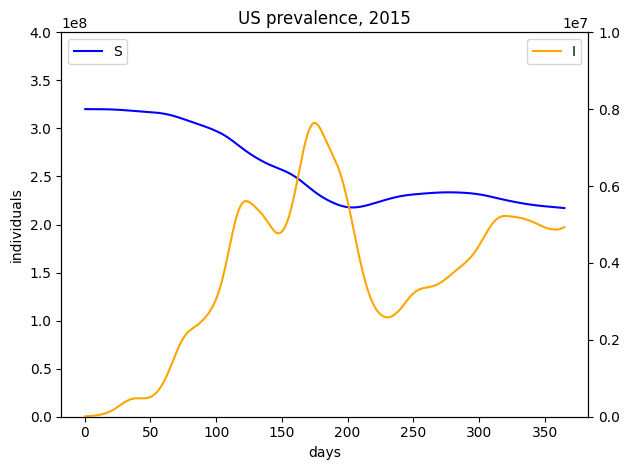

In [4]:
import matplotlib.pyplot as plt

# Plot global S and I
fig, ax = plt.subplots()
ax2 = ax.twinx()

x_axis = [t.tausum for t in out.ctx.clock.ticks]
line1 = ax.plot(x_axis, out.prevalence[:, :, 0].sum(axis=1), label="S", color="blue")
line2 = ax2.plot(x_axis, out.prevalence[:, :, 1].sum(axis=1), label="I", color="orange")

ax.set_ylim(bottom=0, top=4e8)
ax2.set_ylim(bottom=0, top=1e7)
ax.set_title("US prevalence, 2015")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()

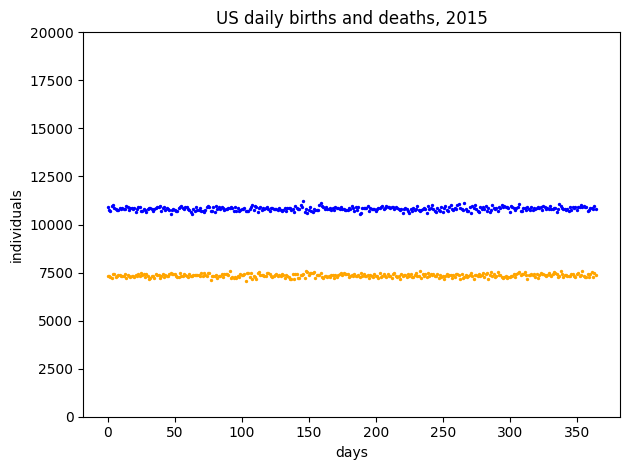

In [5]:
from epymorph.util import stridesum

# Plot births and deaths
fig, ax = plt.subplots()

x_axis = np.arange(out.ctx.clock.num_days)
ax.scatter(
    x_axis,
    stridesum(out.incidence[:, :, 3].sum(axis=1), 2),
    s=2,
    label="births",
    color="blue",
)
ax.scatter(
    x_axis,
    stridesum(out.incidence[:, :, 4:7].sum(axis=(1, 2)), 2),
    s=2,
    label="deaths",
    color="orange",
)

ax.set_title("US daily births and deaths, 2015")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
ax.set_ylim(bottom=0, top=2e4)

fig.tight_layout()
plt.show()

## Analysis

NIH reported 3.978 million births in the US in 2015. https://pubmed.ncbi.nlm.nih.gov/27648876/

And it reported 2.712 million deaths. https://pubmed.ncbi.nlm.nih.gov/29235985/

Are we in that neighborhood?

In [6]:
births_timeline = adjusted_prevalence[:, :, 3].sum(axis=1)
total_births = -births_timeline[-1]

print(
    f"Births: {total_births:,} ({total_births / 3.978e6:.1%} of 3.978 million) is pretty close!"
)

deaths_timeline = adjusted_prevalence[:, :, 4].sum(axis=1)
total_deaths = deaths_timeline[-1]

print(
    f"Deaths: {total_deaths:,} ({total_deaths / 2.712e6:.1%} of 2.712 million) is pretty close!"
)

Births: 3,951,406 (99.3% of 3.978 million) is pretty close!
Deaths: 2,683,344 (98.9% of 2.712 million) is pretty close!


Or we can sum all the incidences for the birth- and death-related events to get the same number.

In [7]:
# Births: event index 3
print(f"Births: {out.incidence[:, :, 3].sum():,}")

# Deaths: event indices 4, 5, and 6
print(f"Deaths: {out.incidence[:, :, 4:7].sum():,}")

Births: 3,951,406
Deaths: 2,683,344
